In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import pathlib
from dataclasses import dataclass, field
from typing import List, Dict, Any, Optional
import gymnasium

from approximation import semi_gradient_sarsa
import featurize
from env import get_four_rooms_env

np.set_printoptions(precision=2, suppress=True)

EXPERIMENT_BASE_DIR = pathlib.Path("experiments")
EXPERIMENT_BASE_DIR.mkdir(exist_ok=True)

FIG_BASE_DIR = pathlib.Path("figures")
FIG_BASE_DIR.mkdir(exist_ok=True)

In [2]:
NUM_EXPERIMENTS = 100
NUM_EPISODES = 100
ALPHA = 0.1
EPSILON = 0.1
GAMMA = 0.99

@dataclass
class ExperimentConfig:
    n_experiments: int = field(default=NUM_EXPERIMENTS)
    n_episodes: int = field(default=NUM_EPISODES)
    alpha: float = field(default=ALPHA)
    epsilon: float = field(default=EPSILON)
    gamma: float = field(default=GAMMA)
    check_points: Optional[set] = field(default=None)

    def __repr__(self):
        return f'ExperimentConfig(n_experiments={self.n_experiments}, n_episodes={self.n_episodes}, alpha={self.alpha}, epsilon={self.epsilon}, gamma={self.gamma})'


def run_experiment(env, featurizer, config: ExperimentConfig, mean_td=False):
    n_experiments = config.n_experiments
    n_episodes = config.n_episodes
    weight_check_points = config.check_points
    alpha = config.alpha
    epsilon = config.epsilon
    gamma = config.gamma
    steps_over_experiments = np.zeros((n_experiments, n_episodes))
    if weight_check_points is not None:
        checkpoints_per_experiment = np.zeros((n_experiments, len(weight_check_points), featurizer.n_features))

    for i in tqdm(range(n_experiments), desc='Experiment progress for featurizer {}'.format(featurizer), position=0, leave=True, unit='experiment'):
        w, steps_per_episode, saved_w = semi_gradient_sarsa(env, n_episodes, alpha, epsilon, gamma, featurizer=featurizer, check_points=weight_check_points, mean_td=mean_td)
        steps_over_experiments[i] = steps_per_episode
        if weight_check_points is not None:
            checkpoints_per_experiment[i] = saved_w
    return steps_over_experiments, checkpoints_per_experiment if weight_check_points is not None else None

def plot_steps_per_episode_experiment(steps_over_experiments, featurizers, config: ExperimentConfig, title, save_path:str=None):
    num_experiments = config.n_experiments
    num_episodes = config.n_episodes
    num_featurizers = len(featurizers)
    alpha, epsilon, gamma = config.alpha, config.epsilon, config.gamma
    mean_steps_per_episode = np.mean(steps_over_experiments, axis=1)
    std_steps_per_episode = np.std(steps_over_experiments, axis=1)
    error = std_steps_per_episode / np.sqrt(num_experiments)

    lower_bound = np.min(steps_over_experiments).astype(int)

    plt.figure(figsize=(15, 10))

    for f in range(num_featurizers):
        plt.plot(mean_steps_per_episode[f], label=f'{featurizers[f]}')
        plt.fill_between(range(num_episodes), mean_steps_per_episode[f] - error[f], mean_steps_per_episode[f] + error[f], alpha=0.2)

    if title is None:
        title = ''
    title += f' | α={alpha}, ε={epsilon}, γ={gamma}'
        
    plt.title(title)
    plt.xlabel(f'Episodes \n(Averaged over {num_experiments} experiments)')
    plt.ylabel('Steps per episode')
    plt.hlines(lower_bound, 0, num_episodes, colors='r', linestyles='dashed', label=f'Lower bound ({lower_bound})')
    plt.ylim(bottom=lower_bound - 10)
    plt.legend(fontsize='small')

    if save_path is not None:
        plt.savefig(FIG_BASE_DIR / save_path)

    plt.show()

featurizers_to_str = lambda featurizers: "|".join([str(f) for f in featurizers])

def save_experiment_results(experiment_results, featurizers, config: ExperimentConfig, file_name: str, check_points: Optional[np.ndarray] =None):
    experiment_results_path = EXPERIMENT_BASE_DIR / file_name
    with open(experiment_results_path, 'wb') as f:
        pickle.dump({
            'experiment_results': experiment_results,
            'featurizers': featurizers_to_str(featurizers),
            'config': str(config),
            'check_points': np.array(check_points) if check_points is not None else np.array([])
        }, f)
    print(f'Saved experiment results to {experiment_results_path}')

def load_experiment_results(file_name: str):
    experiment_results_path = EXPERIMENT_BASE_DIR / file_name
    with open(experiment_results_path, 'rb') as f:
        data = pickle.load(f)
    return data['experiment_results'], data['featurizers'], data['config'], data.get('check_points', np.array([]))


In [3]:
base_config = ExperimentConfig()
env = get_four_rooms_env()

### Comparing Tabular vs Tile Coding

In [4]:
tabular_featurizer = featurize.GridWorldTabularFeaturizer(env, include_bias=False)
tabular_featurizer_with_bias = featurize.GridWorldTabularFeaturizer(env)
tile_2_by_2_featurizer = featurize.GridWorldTileFeaturizer(env, 2.)

composition_of_tile_and_tabular_featurizer = featurize.CompositionFeaturizer(
    [tabular_featurizer_with_bias, tile_2_by_2_featurizer]
)

tile_1_by_2_featurizer = featurize.GridWorldTileFeaturizer(env, [1.,2.])

tile_composition_featurizer = featurize.CompositionFeaturizer([
    tile_1_by_2_featurizer, tile_2_by_2_featurizer
])

big_composition_of_tile_and_tabular_featurizer = featurize.CompositionFeaturizer([
    tabular_featurizer_with_bias, tile_2_by_2_featurizer, tile_1_by_2_featurizer
])

[5, 5]
[11, 5]


In [5]:
FEATURIZER_COMPARISON_PICKLE = "featurizer_comparison.pickle"

featurizers = [tabular_featurizer, tabular_featurizer_with_bias, tile_1_by_2_featurizer, tile_2_by_2_featurizer, tile_composition_featurizer, composition_of_tile_and_tabular_featurizer, big_composition_of_tile_and_tabular_featurizer]
NUM_FEATURIZERS = len(featurizers)

try:
    experiment_results, featurizers_str, config, _ = load_experiment_results(FEATURIZER_COMPARISON_PICKLE)
    if featurizers_to_str(featurizers) != featurizers_str or str(base_config) != config:
        raise FileNotFoundError

except FileNotFoundError:
    experiment_results = np.zeros((NUM_FEATURIZERS, NUM_EXPERIMENTS, NUM_EPISODES))
    for f in range(NUM_FEATURIZERS):
        steps_over_experiments, _ = run_experiment(env, featurizers[f], base_config)
        experiment_results[f] = steps_over_experiments
    save_experiment_results(experiment_results, featurizers, base_config, FEATURIZER_COMPARISON_PICKLE)

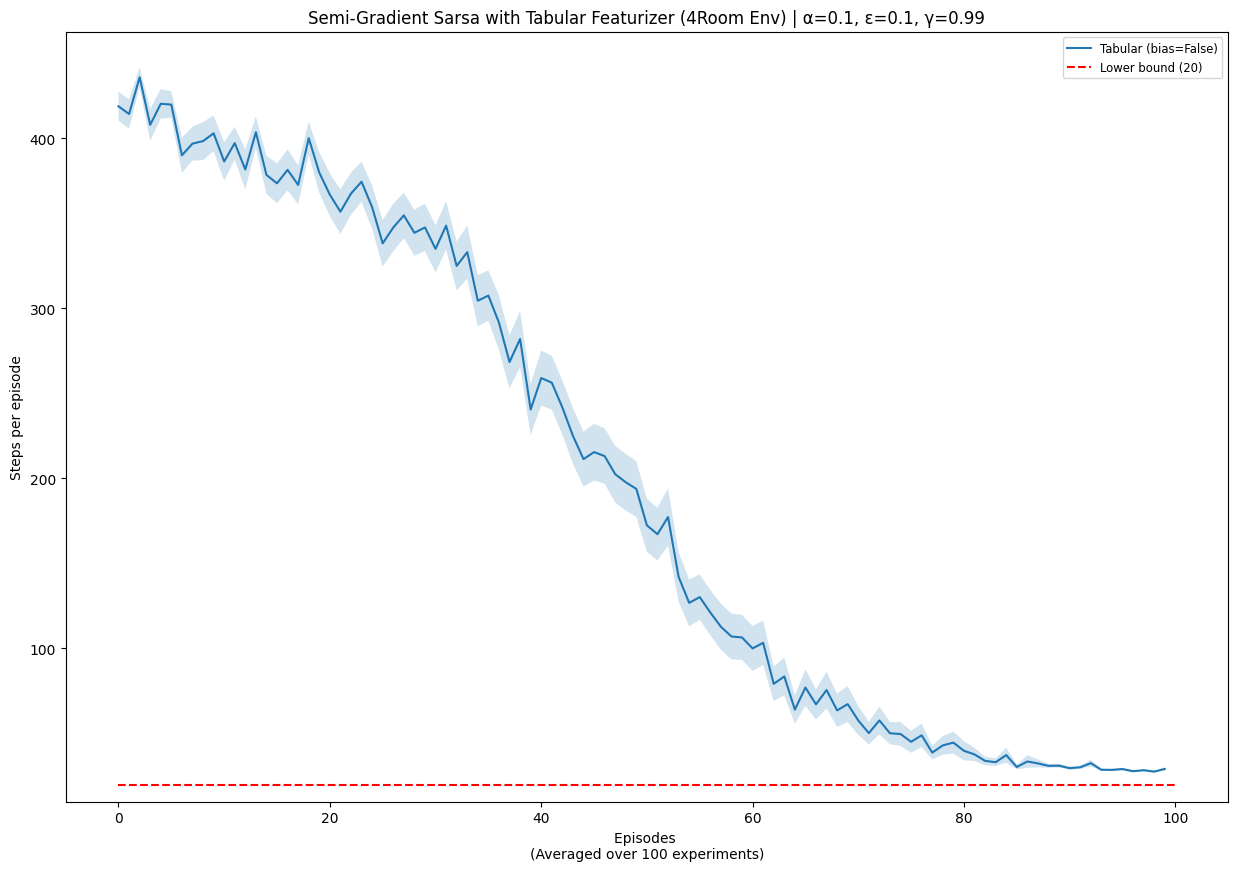

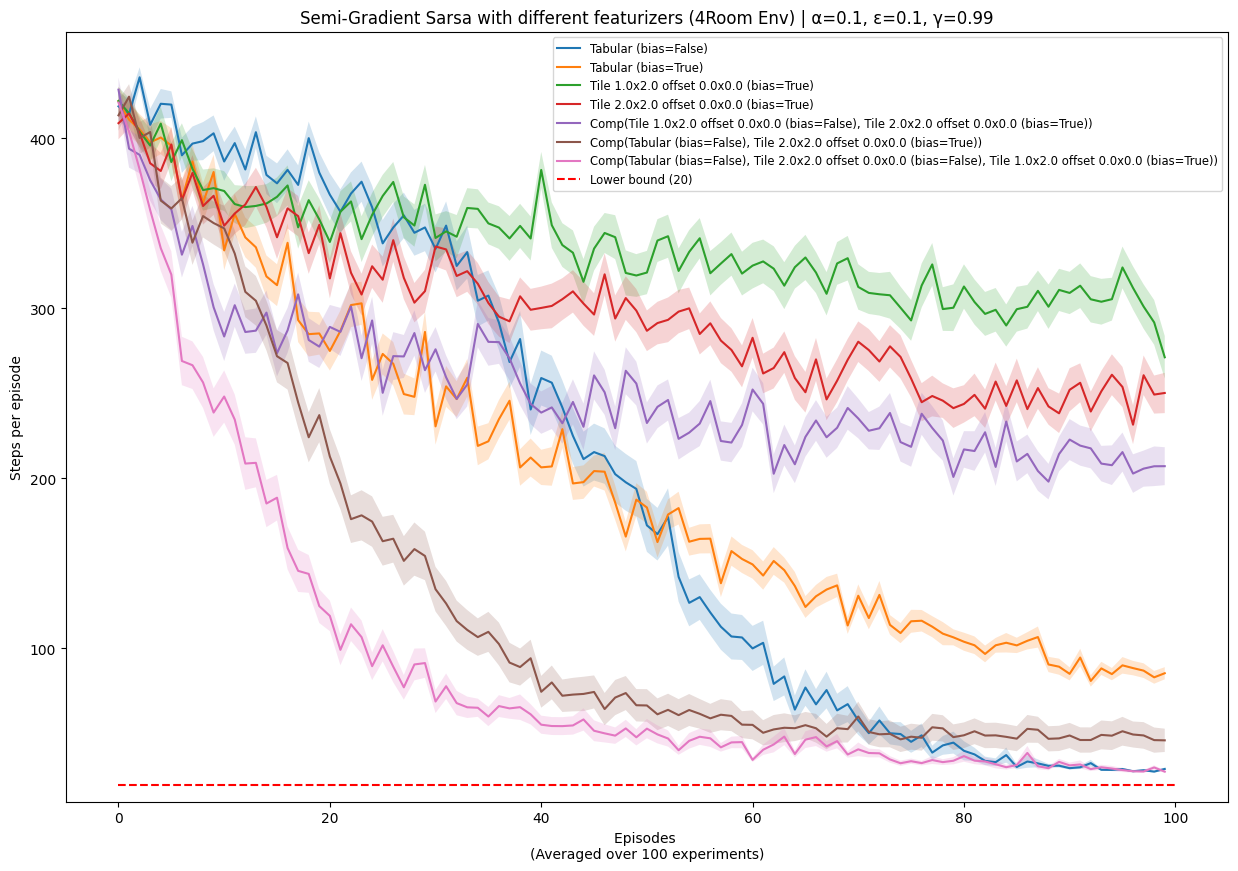

In [6]:
plot_steps_per_episode_experiment(experiment_results[0][np.newaxis], [featurizers[0]], base_config, title=f'Semi-Gradient Sarsa with Tabular Featurizer (4Room Env)', save_path='tabular_featurizer_4Room.png')
plot_steps_per_episode_experiment(experiment_results, featurizers, base_config, title=f'Semi-Gradient Sarsa with different featurizers (4Room Env)', save_path='featurizer_comparison_4Room.png')

In [7]:
metrics = {
    'Featurizer': [str(f) for f in featurizers],
    'Number of features': [f.n_features for f in featurizers],
    'Avg steps per episode': [],
    'Std Dev of Steps/Episode': [],
    'Fastest episode (avg)': [],
    'Slowest episode (avg)': [],
}

for f_ndx in range(len(featurizers)):
    experiment_means = np.mean(experiment_results[f_ndx], axis=0)
    metrics['Avg steps per episode'].append(np.mean(experiment_means))
    metrics['Std Dev of Steps/Episode'].append(np.mean(np.std(experiment_results[f_ndx], axis=0)))
    metrics['Fastest episode (avg)'].append(np.min(experiment_means))
    metrics['Slowest episode (avg)'].append(np.max(experiment_means))
df = pd.DataFrame(metrics).sort_values(by='Number of features')

df_styled = df.style.format({
    'Avg steps per episode': '{:.2f}',
    'Std Dev of Steps/Episode': '{:.2f}',
    'Fastest episode (avg)': '{:.2f}',
    'Slowest episode (avg)': '{:.2f}'
}).set_properties(**{'text-align': 'left'}).hide(axis='index')

# Display the DataFrame
display(df_styled)

### Taking a Step Back From State Aggregation

Instead of using state aggregation, we can instead just use raw state-action values as our features... 

Let's explore this idea

In [8]:
non_aggregtated_experiment_config = ExperimentConfig(n_experiments=10, n_episodes=1000, alpha=0.01)

state_action_featurizer = featurize.StateActionFeaturizer([11,11], 4, normalize=True, include_bias=True)

In [9]:
SIMPLE_STATE_ACTION_FEATURIZER_PICKLE = "simple_state_action_featurizer.pickle"
try:
    experiment_results_no_aggregation, featurizers_str, config, _ = load_experiment_results(SIMPLE_STATE_ACTION_FEATURIZER_PICKLE)
    if str(non_aggregtated_experiment_config) != config or featurizers_str != featurizers_to_str([state_action_featurizer]):
        raise FileNotFoundError

except FileNotFoundError:
    experiment_results_no_aggregation, _ = run_experiment(env, state_action_featurizer, non_aggregtated_experiment_config)
    save_experiment_results(experiment_results_no_aggregation, [state_action_featurizer], non_aggregtated_experiment_config, SIMPLE_STATE_ACTION_FEATURIZER_PICKLE)

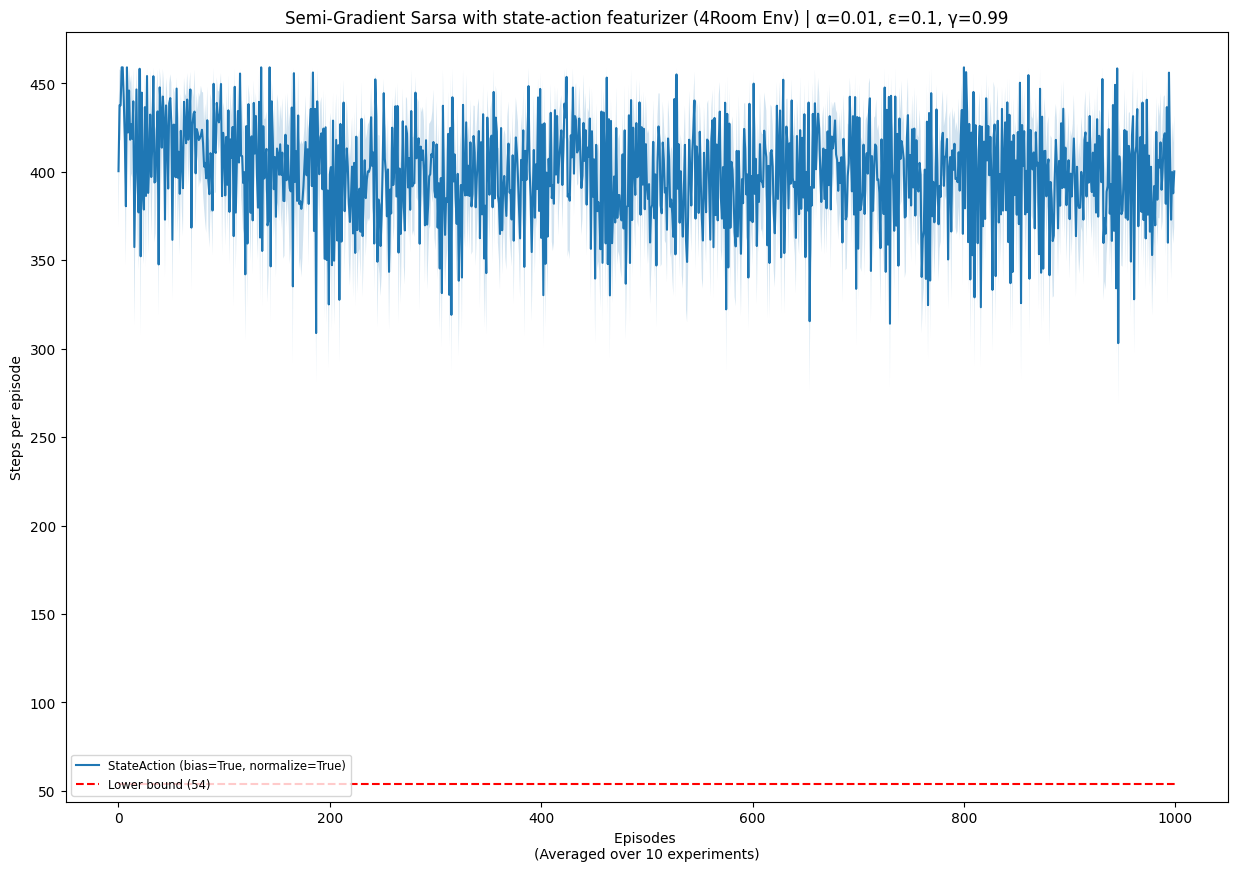

In [10]:
plot_steps_per_episode_experiment(experiment_results_no_aggregation[np.newaxis], [state_action_featurizer], non_aggregtated_experiment_config, title=f'Semi-Gradient Sarsa with state-action featurizer (4Room Env)', save_path='state_action_featurizer_4Room.png')

#### Seems that Simple State Action Features don't work well

This is a simple experiment, however, the outcome can be expected. Since a simple state-action feature representation is way too simple to capture complex relationships between states and actions.

In [11]:
l1_featurizer = featurize.FunctionalFeaturizer(lambda s,a: np.abs(s[0] - env.unwrapped.goal_pos[0]) + np.abs(s[1] - env.unwrapped.goal_pos[1]), label="L1", normalize_factor=20)
l2_featurizer = featurize.FunctionalFeaturizer(lambda s,a: np.sqrt((s[0] - env.unwrapped.goal_pos[0])**2 + (s[1] - env.unwrapped.goal_pos[1])**2), label="L2", normalize_factor=14.1)
quadrant_featurizer = featurize.FunctionalFeaturizer(lambda s,a: env.unwrapped.get_quadrant(s), label="Quadrant", normalize_factor=4.0)
state_action_features_with_l1_l2_quadrant = featurize.CompositionFeaturizer([l1_featurizer, l2_featurizer, quadrant_featurizer, featurize.StateActionFeaturizer([11,11], 4, normalize=True, include_bias=True)])

In [12]:
STATE_ACTION_WITH_HEURISTIC_FEATURIZER_PICKLE = "state_action_with_heuristic_featurizer.pickle"

try:
    experiment_results_no_aggregation_hueristics, featurizers_str, config, _ = load_experiment_results(STATE_ACTION_WITH_HEURISTIC_FEATURIZER_PICKLE)
    if str(non_aggregtated_experiment_config) != config or featurizers_str != featurizers_to_str([state_action_features_with_l1_l2_quadrant]):
        raise FileNotFoundError
    
except FileNotFoundError:
    experiment_results_no_aggregation_hueristics, _ = run_experiment(env, state_action_features_with_l1_l2_quadrant, non_aggregtated_experiment_config)
    save_experiment_results(experiment_results_no_aggregation_hueristics, [state_action_features_with_l1_l2_quadrant], non_aggregtated_experiment_config, STATE_ACTION_WITH_HEURISTIC_FEATURIZER_PICKLE)

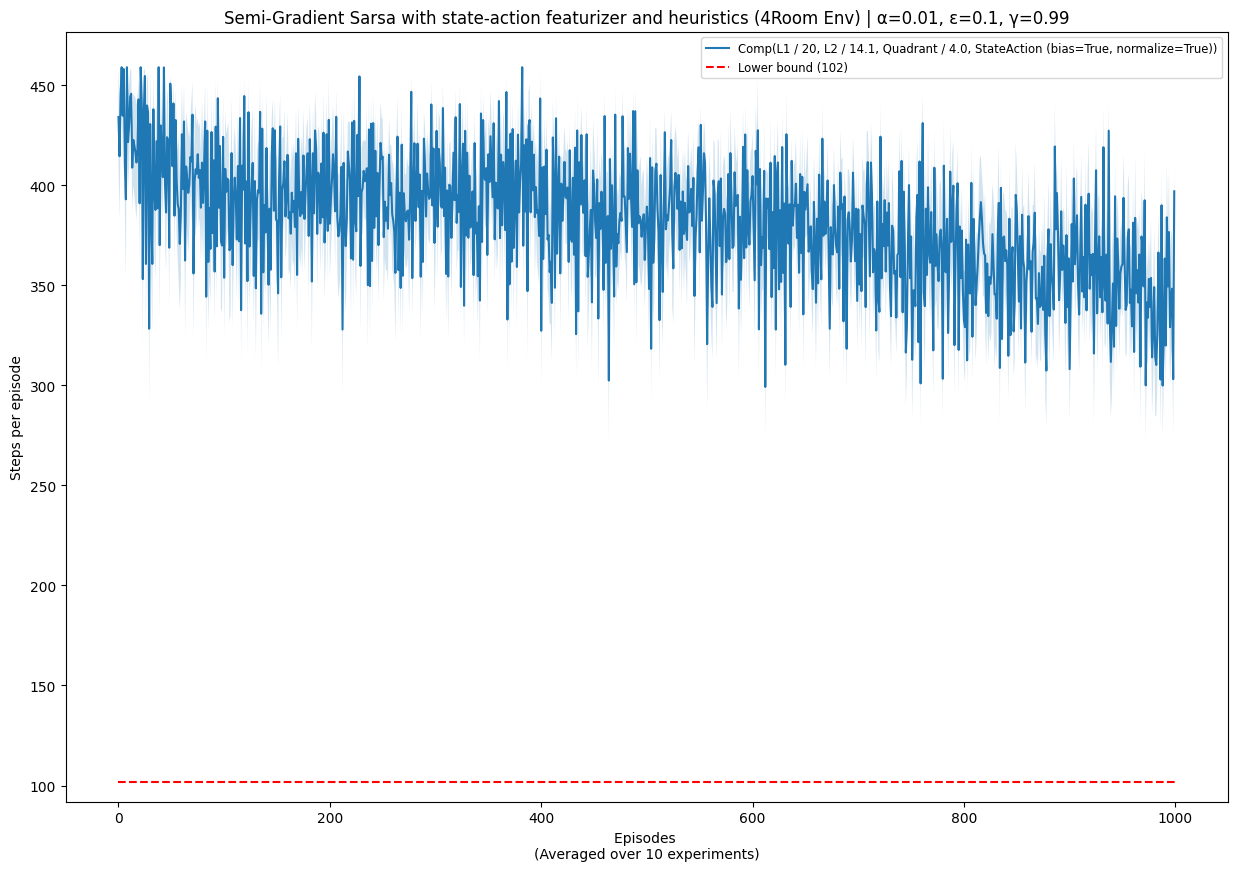

In [13]:
plot_steps_per_episode_experiment(experiment_results_no_aggregation_hueristics[np.newaxis], [state_action_features_with_l1_l2_quadrant], non_aggregtated_experiment_config, title=f'Semi-Gradient Sarsa with state-action featurizer and heuristics (4Room Env)', save_path='state_action_with_heuristics_featurizer_4Room.png')

# Mountain Car

In [14]:
def plot_cost_to_go(env, featurizer, weights, title, save_path:str=None, step=50):
    """
    Plots the cost-to-go function for the given featurizer

    Args:
        env (gym.Env): The environment
        featurizer (Featurizer): The featurizer
        weights (np.ndarray): The weights
        title (str): Title of the plot
        save_path (str): Path to save the plot
        step (int): step size for the grid
    """
    state_dims = list(zip(mountain_car_env.observation_space.low, mountain_car_env.observation_space.high))
    step_size = [(high - low) / step for low, high in state_dims]
    x = np.arange(state_dims[0][0], state_dims[0][1], step_size[0])
    y = np.arange(state_dims[1][0], state_dims[1][1], step_size[1])
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            best_cost = -np.inf
            for a in range(env.action_space.n):
                cost = -np.dot(featurizer.featurize((X[i,j], Y[i,j]), a).T, weights)
                best_cost = max(best_cost, cost)
            Z[i,j] = best_cost
    
    plt.figure(figsize=(10, 10))

    # create 3D surface plot
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

    # plt.contourf(X, Y, Z, cmap='viridis', origin='lower')
    # plt.colorbar()
    plt.title(title)

    # x axis is Position and y axis is Velocity
    plt.xlabel('Position')
    plt.ylabel('Velocity')

    # change the view angle
    ax.view_init(60, 45)
    
    if save_path is not None:
        plt.savefig(FIG_BASE_DIR / save_path)
    plt.show()

def plot_steps_per_episode_across_configs(steps_over_experiments, featurizer, configs: List[ExperimentConfig], title, save_path:str=None):
    """
    This is a cheeky copy of the plot_steps_per_episode_experiment function, but instead of comparing featurizers, it compares different configurations of the same featurizer

    Args:
        steps_over_experiments (np.ndarray): The steps over experiments
        featurizer (Featurizer): The featurizer
        configs (List[ExperimentConfig]): The configurations
        title (str): Title of the plot
        save_path (str): Path to save the plot
    """
    num_experiments = steps_over_experiments.shape[1]
    num_episodes = steps_over_experiments.shape[2]
    mean_steps_per_episode = np.mean(steps_over_experiments, axis=1)
    std_steps_per_episode = np.std(steps_over_experiments, axis=1)
    error = std_steps_per_episode / np.sqrt(num_experiments)
    num_configs = len(configs)

    lower_bound = np.min(steps_over_experiments).astype(int)

    differing_fields = set()
    for c in range(num_configs):
        differing_fields = differing_fields.symmetric_difference(configs[c].__dict__.keys())
    differing_fields.add('check_points')

    plt.figure(figsize=(15, 10))

    for c in range(num_configs):
        identifier = ' | '.join([f'{field}={configs[c].__dict__[field]}' for field in differing_fields])
        plt.plot(mean_steps_per_episode[c], label=f'{identifier}')
        plt.fill_between(range(num_episodes), mean_steps_per_episode[c] - error[c], mean_steps_per_episode[c] + error[c], alpha=0.2)

    if title is None:
        title = ''
        
    plt.title(title)
    plt.xlabel(f'Episodes \n(Averaged over {num_experiments} experiments)')
    plt.ylabel('Steps per episode')
    plt.hlines(lower_bound, 0, num_episodes, colors='r', linestyles='dashed', label=f'Lower bound ({lower_bound})')
    plt.ylim(bottom=lower_bound - 10)
    plt.legend(fontsize='small')

    if save_path is not None:
        plt.savefig(FIG_BASE_DIR / save_path)

    plt.show()

In [15]:
mountain_car_env = gymnasium.make("MountainCar-v0")
tile_size = 8.0

In [16]:
car_state_bounds = list(zip(mountain_car_env.observation_space.low, mountain_car_env.observation_space.high))
car_action_bounds = [0, mountain_car_env.action_space.n]
car_tile_dims = [(car_state_bounds[i][1] - car_state_bounds[i][0]) / tile_size for i in range(len(car_state_bounds))]
car_state_bounds, car_action_bounds, car_tile_dims

([(-1.2, 0.6), (-0.07, 0.07)],
 [0, 3],
 [0.22500000894069672, 0.017500000074505806])

In [17]:
car_featurizer = featurize.MountainCarTileFeaturizer(mountain_car_env, include_bias=True)

/var/folders/dn/qrl3gd_j3w5csrv58d43z62r0000gn/T/ipykernel_87021/2178184854.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = best_cost


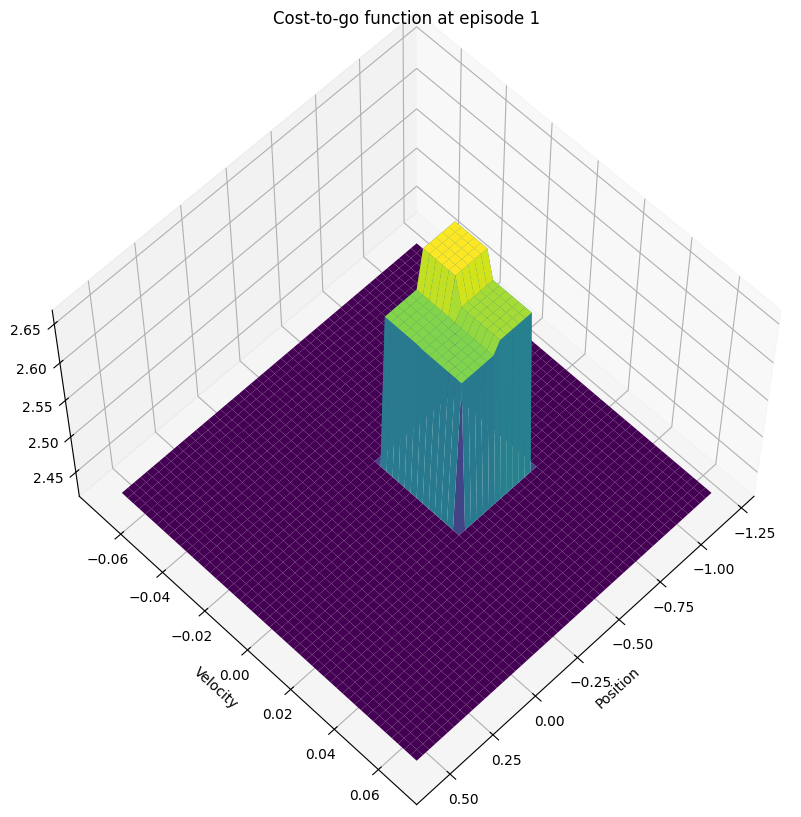

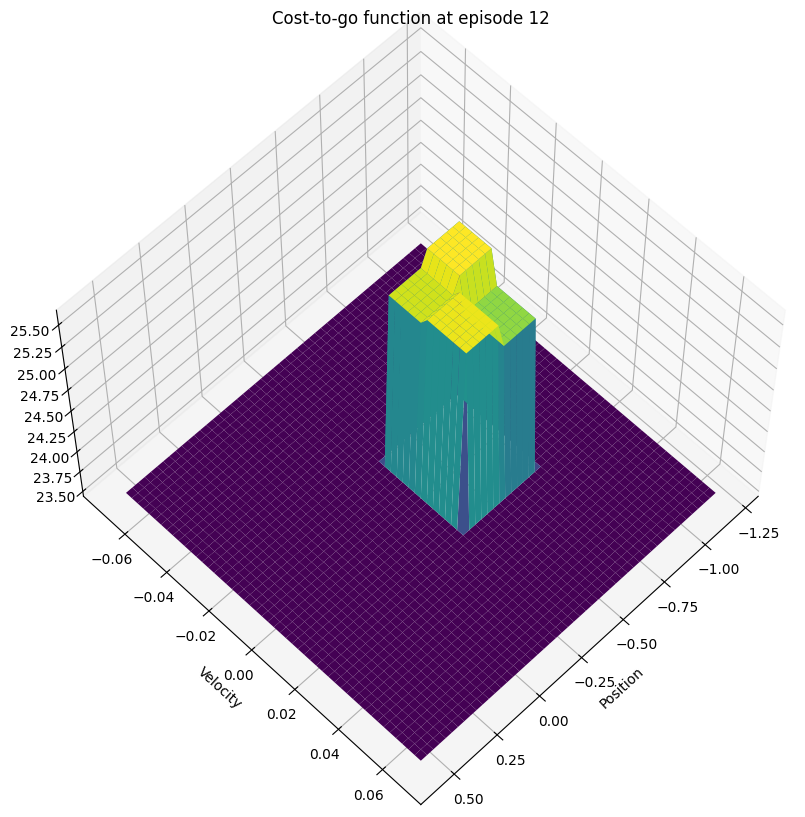

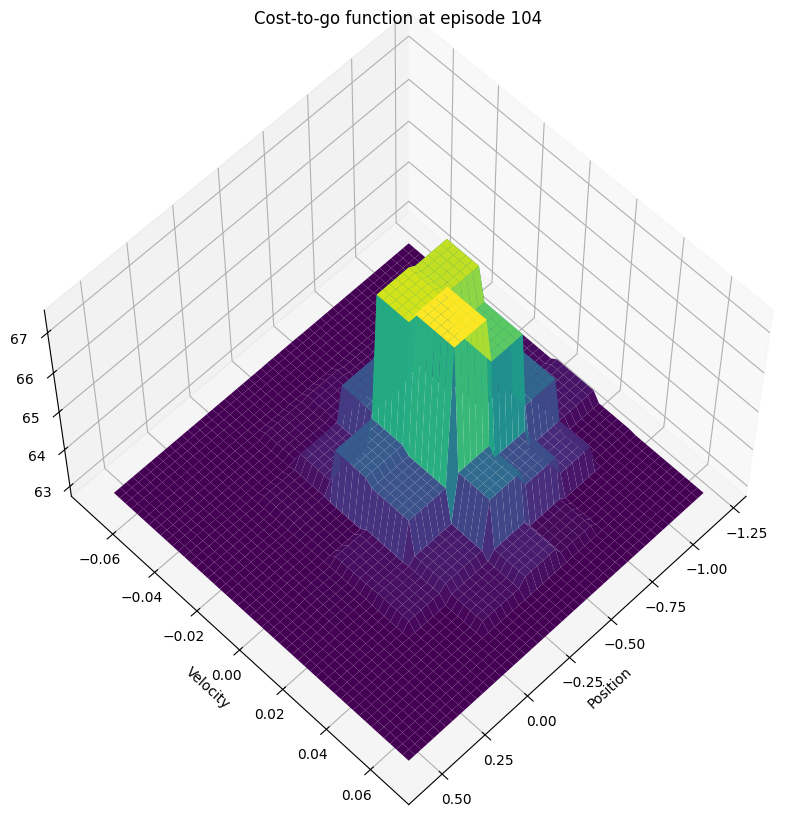

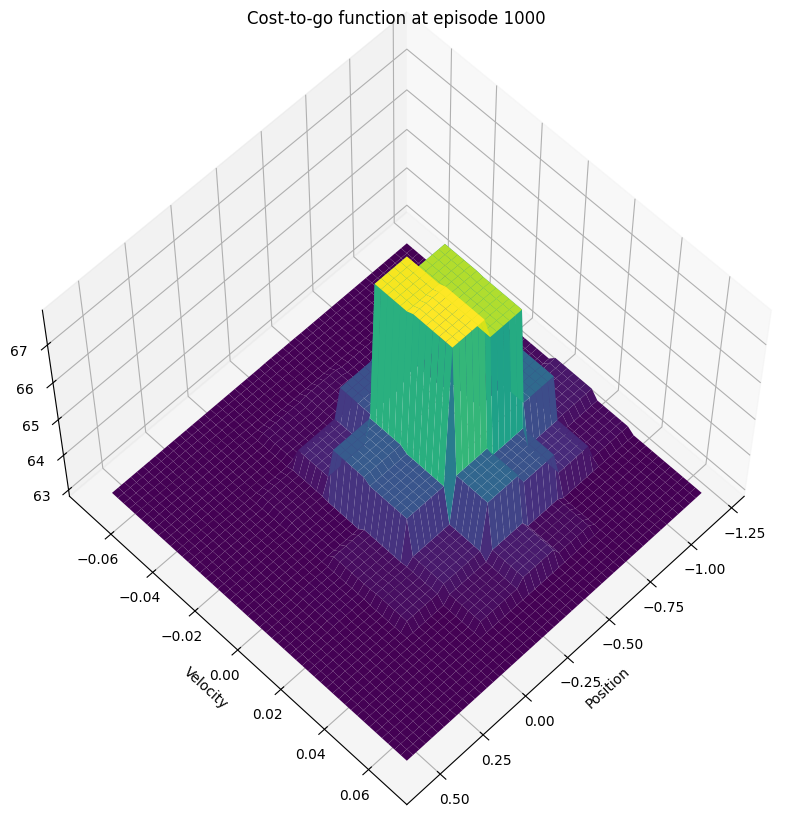

In [18]:
MOUNTAIN_CAR_BASE_PICKLE = "mountain_car_base.pickle"
check_points = {1, 12, 104, 1000}
base_config = ExperimentConfig(n_experiments=1, n_episodes=1000, alpha=0.1 / 8, epsilon=0.0, gamma=0.99, check_points=check_points)
sorted_check_points = list(sorted(list(check_points)))

try:
    steps_over_experiments, featurizers_str, config, checkpoints_per_experiment = load_experiment_results(MOUNTAIN_CAR_BASE_PICKLE)
    checkpoints_per_experiment = checkpoints_per_experiment.reshape((len(check_points), car_featurizer.n_features))
    if str(base_config) != config:
        raise FileNotFoundError
except FileNotFoundError:
    steps_over_experiments, checkpoints_per_experiment = run_experiment(mountain_car_env, car_featurizer, base_config)
    checkpoints_per_experiment = checkpoints_per_experiment.reshape((len(check_points), car_featurizer.n_features))
    save_experiment_results(steps_over_experiments, [car_featurizer], base_config, MOUNTAIN_CAR_BASE_PICKLE, checkpoints_per_experiment)
    checkpoints_per_experiment = checkpoints_per_experiment
for i, checkpoint in enumerate(sorted_check_points):
    plot_cost_to_go(mountain_car_env, car_featurizer, checkpoints_per_experiment[i], f'Cost-to-go function at episode {checkpoint}', save_path=f'cost_to_go_{checkpoint}.png')

In [19]:
mountain_car_tile_featurizer = featurize.MountainCarTileFeaturizer(mountain_car_env, include_bias=True)

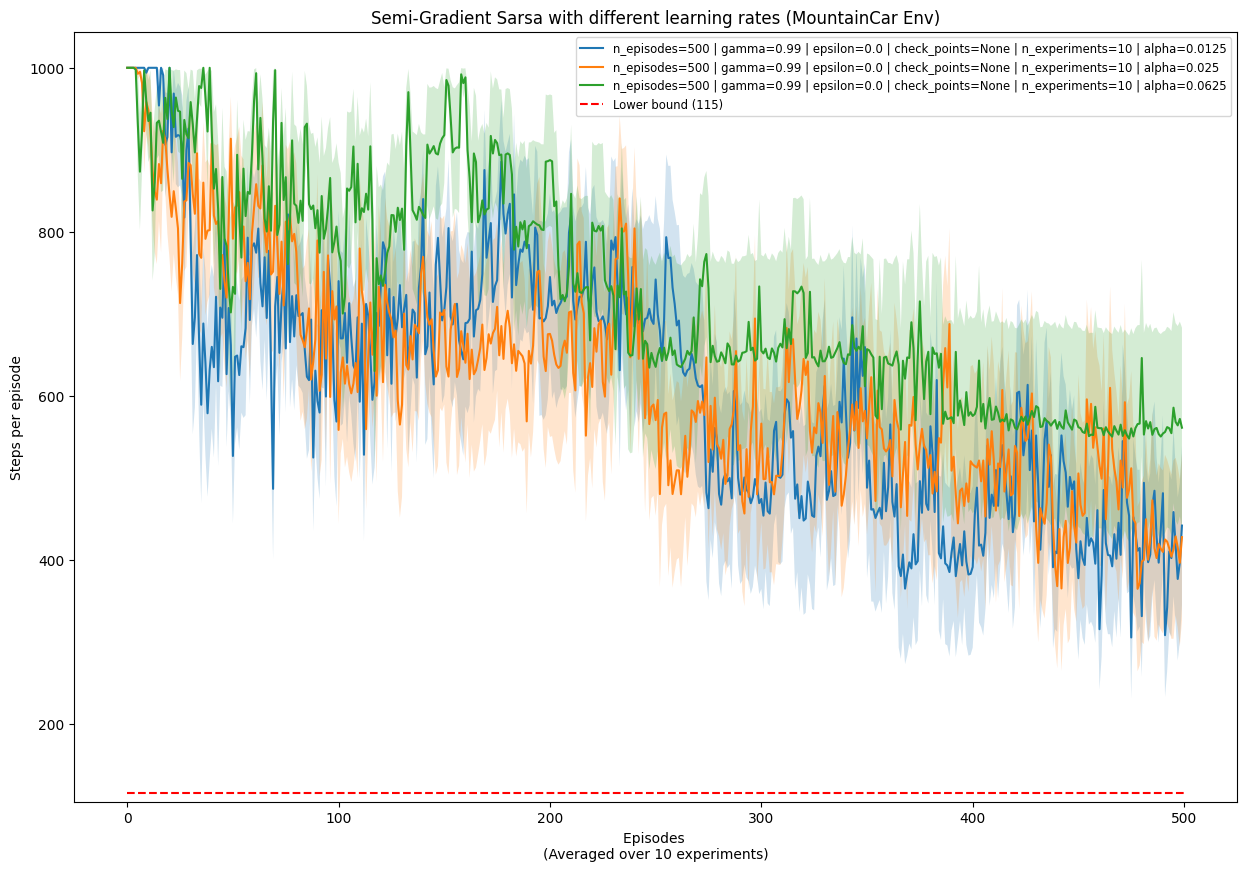

In [20]:
mountain_car_env = gymnasium.make("MountainCar-v0", max_episode_steps=1000)
alphas = [0.1 / tile_size, 0.2 / tile_size, 0.5 / tile_size]
mountain_configs = [ExperimentConfig(n_experiments=10, n_episodes=500, alpha=alpha, epsilon=0.0, gamma=0.99) for alpha in alphas]

save_paths = [f'mountain_car_learning_with_{alpha}.pickle' for alpha in alphas]

assert np.all([c.n_experiments == mountain_configs[0].n_experiments for c in mountain_configs]) and np.all([c.n_episodes == mountain_configs[0].n_episodes for c in mountain_configs]), f'All configs should have the same number of experiments and episodes'

results = np.zeros((len(mountain_configs), mountain_configs[0].n_experiments, mountain_configs[0].n_episodes))

for i, c in enumerate(mountain_configs):
    try:
        steps_over_experiments, featurizers_str, config, check_points = load_experiment_results(save_paths[i])
        if str(c) != config or featurizers_str != featurizers_to_str([mountain_car_tile_featurizer]) and False:
            raise FileNotFoundError
    except FileNotFoundError:
        steps_over_experiments, _ = run_experiment(mountain_car_env, mountain_car_tile_featurizer, c)
        save_experiment_results(steps_over_experiments, [mountain_car_tile_featurizer], c, save_paths[i], check_points)
    
    results[i] = steps_over_experiments

plot_steps_per_episode_across_configs(results, mountain_car_tile_featurizer, mountain_configs, title=f'Semi-Gradient Sarsa with different learning rates (MountainCar Env)', save_path='mountain_car_learning_rates.png')



/var/folders/dn/qrl3gd_j3w5csrv58d43z62r0000gn/T/ipykernel_87021/2178184854.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[i,j] = best_cost


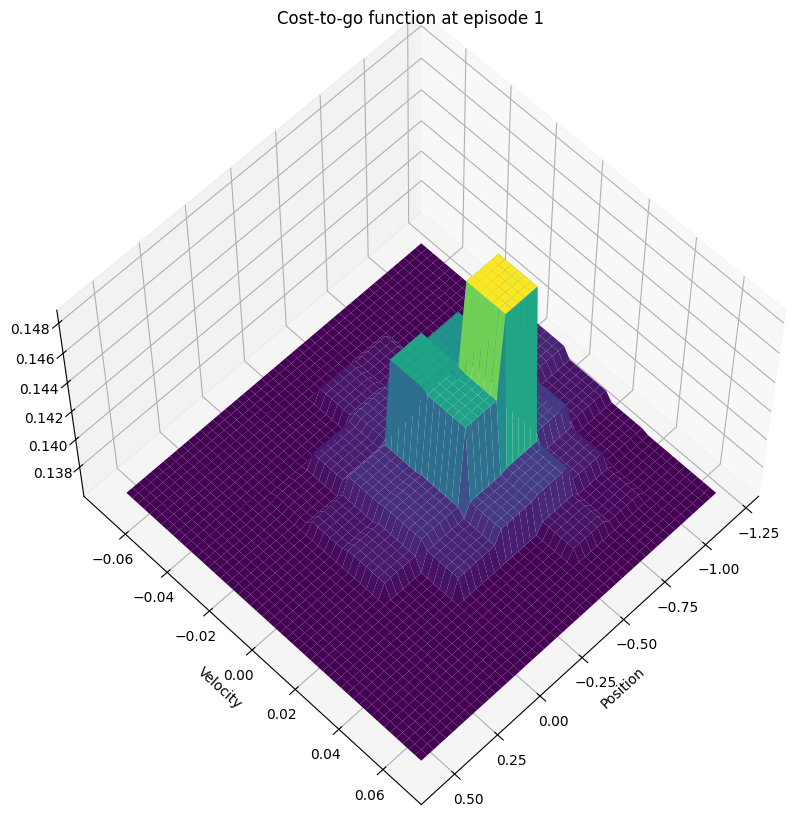

0.001290954799460363


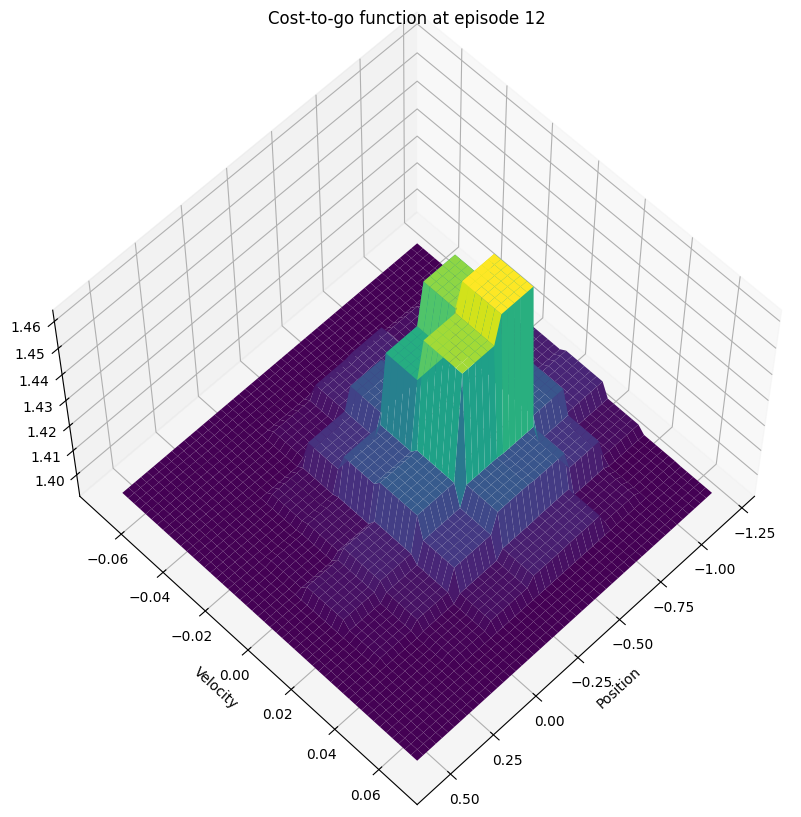

0.012855538534888208


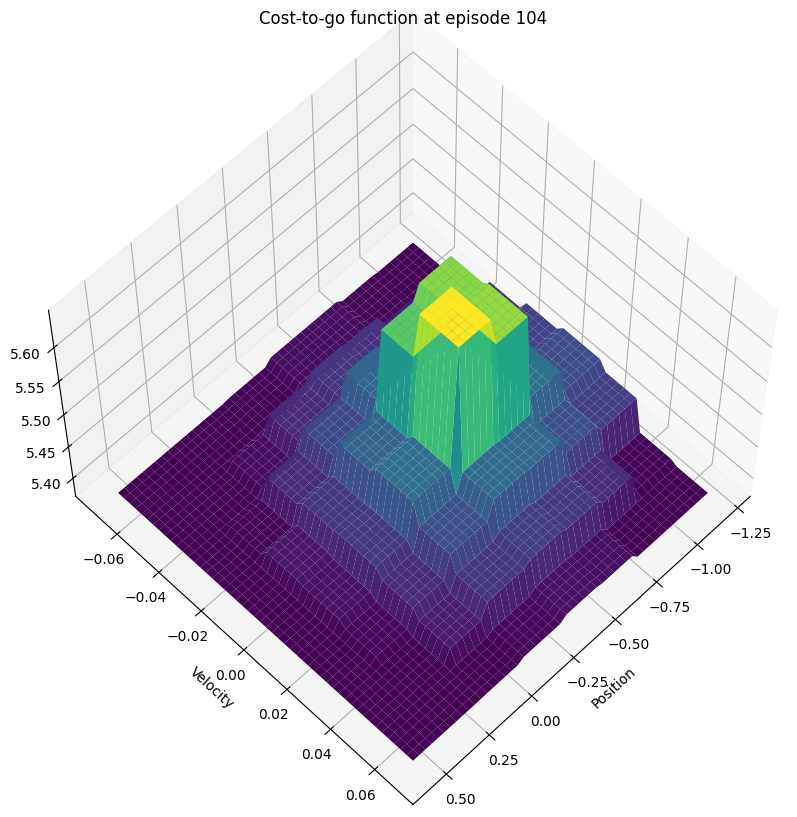

1.8741143796631885


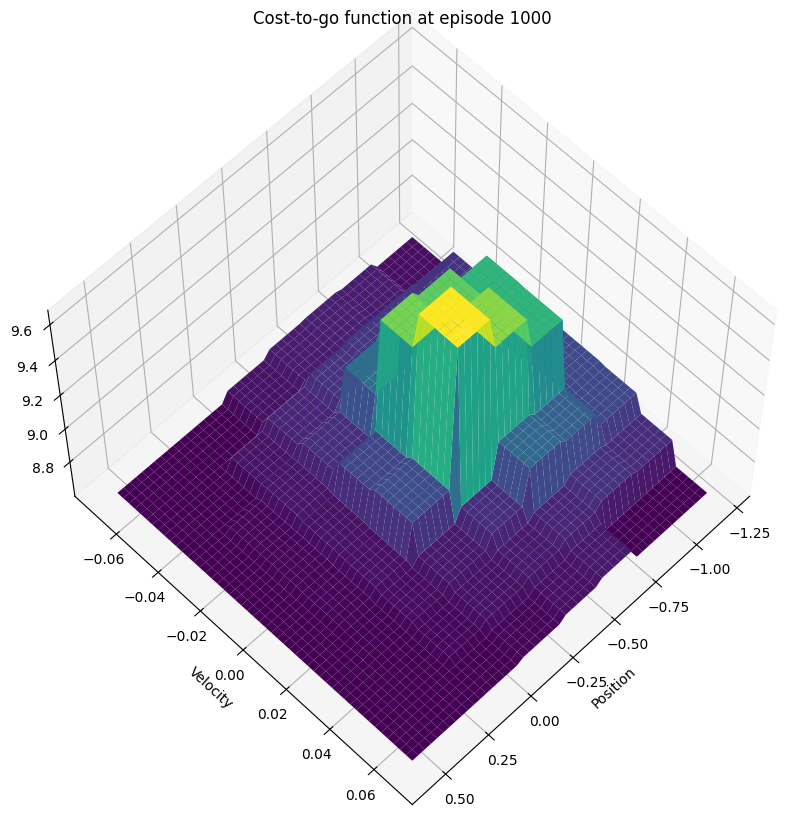

5.896287465481


In [21]:
MOUNTAIN_CAR_MEAN_TD_PICKLE = "mountain_car_mean_td.pickle"
check_points = {1, 12, 104, 1000}
base_config = ExperimentConfig(n_experiments=1, n_episodes=1000, alpha=0.1 / 8, epsilon=0.0, gamma=0.99, check_points=check_points)

try:
    steps_over_experiments, featurizers_str, config, checkpoints_per_experiment = load_experiment_results(MOUNTAIN_CAR_MEAN_TD_PICKLE)
    checkpoints_per_experiment = checkpoints_per_experiment.reshape((len(check_points), car_featurizer.n_features))
    if str(base_config) != config:
        raise FileNotFoundError
except FileNotFoundError:
    steps_over_experiments, checkpoints_per_experiment = run_experiment(mountain_car_env, car_featurizer, base_config, mean_td=True)
    save_experiment_results(steps_over_experiments, [car_featurizer], base_config, MOUNTAIN_CAR_MEAN_TD_PICKLE, checkpoints_per_experiment)
    checkpoints_per_experiment = checkpoints_per_experiment[0]

for i, checkpoint in enumerate(sorted_check_points):
    plot_cost_to_go(mountain_car_env, mountain_car_tile_featurizer, checkpoints_per_experiment[i], f'Cost-to-go function at episode {checkpoint}', save_path=f'cost_to_go_{checkpoint}_mean_td.png')
    print(np.max(checkpoints_per_experiment[i]))

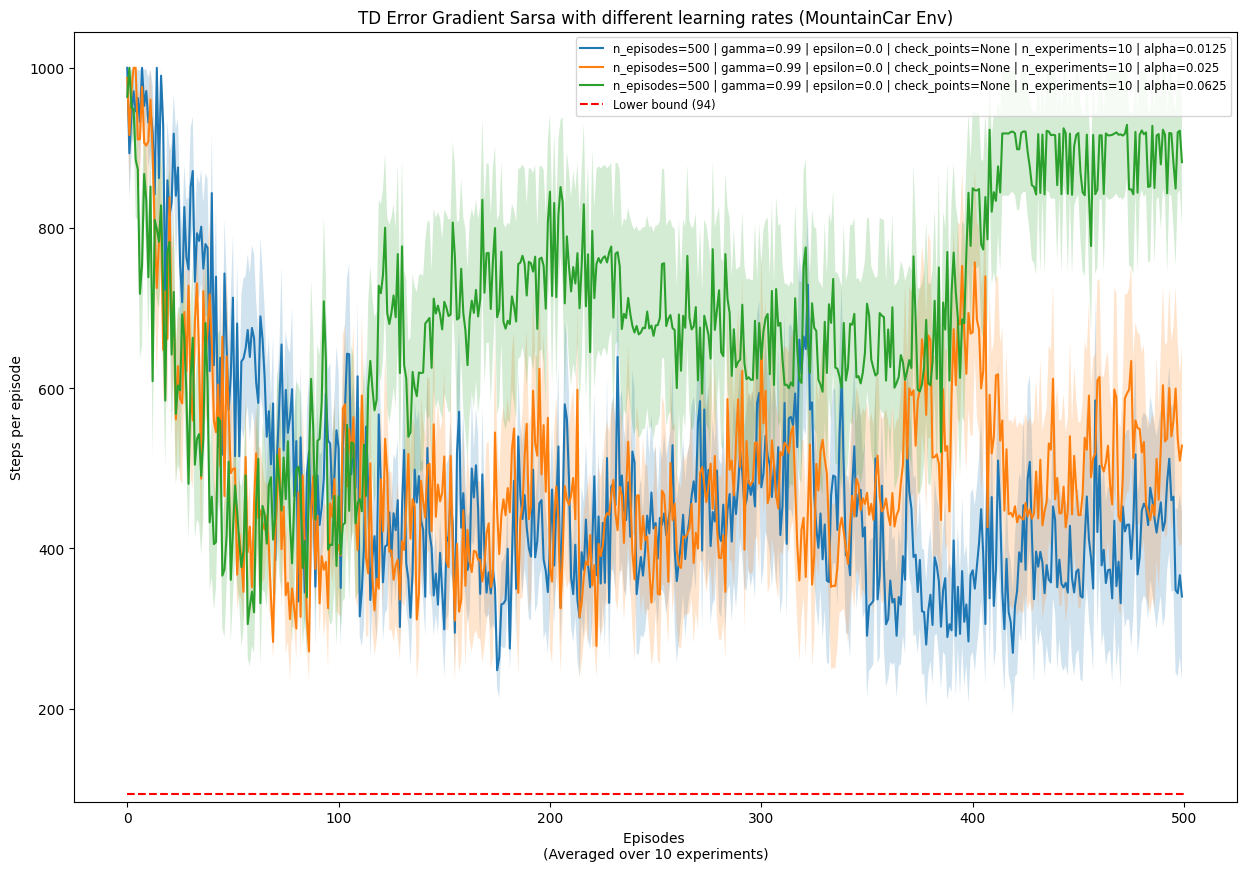

In [22]:
mountain_car_env = gymnasium.make("MountainCar-v0", max_episode_steps=1000)
alphas = [0.1 / tile_size, 0.2 / tile_size, 0.5 / tile_size]
mountain_configs = [ExperimentConfig(n_experiments=10, n_episodes=500, alpha=alpha, epsilon=0.0, gamma=0.99) for alpha in alphas]

save_paths = [f'mountain_car_learning_with_{alpha}_mean_td.pickle' for alpha in alphas]

assert np.all([c.n_experiments == mountain_configs[0].n_experiments for c in mountain_configs]) and np.all([c.n_episodes == mountain_configs[0].n_episodes for c in mountain_configs]), f'All configs should have the same number of experiments and episodes'

results = np.zeros((len(mountain_configs), mountain_configs[0].n_experiments, mountain_configs[0].n_episodes))

for i, c in enumerate(mountain_configs):
    try:
        steps_over_experiments, featurizers_str, config, check_points = load_experiment_results(save_paths[i])
        if str(c) != config or featurizers_str != featurizers_to_str([mountain_car_tile_featurizer]) and False:
            raise FileNotFoundError
    except FileNotFoundError:
        steps_over_experiments, _ = run_experiment(mountain_car_env, mountain_car_tile_featurizer, c, mean_td=True)
        save_experiment_results(steps_over_experiments, [mountain_car_tile_featurizer], c, save_paths[i], check_points)
    
    results[i] = steps_over_experiments

plot_steps_per_episode_across_configs(results, mountain_car_tile_featurizer, mountain_configs, title=f'TD Error Gradient Sarsa with different learning rates (MountainCar Env)', save_path='mountain_car_learning_rates_mean_td.png')

